In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import sys
import pickle
import numpy as np
import torch
import pandas as pd
sys.path.append("/home/wangrr/Analysis/epiRNA/src")
import epiRNA as erna

workdir = "/data/wangrr/Analysis/epiRNA/workdir2/others"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

In [4]:
checkpoints = "/data/wangrr/Analysis/epiRNA/models/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt"
config_file = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"
model = erna.evals.load_model(ckpt=checkpoints, config_yaml=config_file)

In [5]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

m6A_train_samples = ["Adipose-1", "Aorta-1", "Appendix-1", "Esophagus-1", "GOS-1", "Hela-1", "HT29-1", "Hypothalamus-1", "Jejunum-1", "Liver-1", "Prostate-1", "Skin-1", "Testis-1", "Tongue-1", "Trachea-1", "WPMY-1", "MT4-1", "GSC11-1", "iSLK-1", "TIME-1", "mHeart-1", "mSpleen-1", "mLung-1", "mLiver-1", "mCerebrum-1", "mCerebellum-1", "mBrainstem-1", "mHypothalamus-1", "mBMDC-1", "mEF-1", "mNPC-1", "mESC-1", "mStriatum-1", "mPeritoneal_macrophages-1", "mB16-OVA-1", "miPSC-1", "mNSC-1", "mForebrain-1", "mKidney-1", "mHypothalamus-2"]

datainfo = datainfo[datainfo["SID"].isin(m6A_train_samples)].reset_index(drop=True)

ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}

human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)

chrom_kwargs = {
    'human': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    },
    'mouse': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    }
}

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [6]:
rbp_dict_file = "/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl"
with open(rbp_dict_file, "rb") as f:
    rbp_dict = pickle.load(f)['rbp_dict']

human_fasta_loader = erna.pp.FastaLoader(genome["human"]["fasta"])
mouse_fasta_loader = erna.pp.FastaLoader(genome["mouse"]["fasta"])

mouse_generator = erna.pp.DataGenerator(
    fasta_loader=mouse_fasta_loader,
    gtf_df=mouse_gtf_df,
    seq_len=65536,
    bin_size=64
)

human_generator = erna.pp.DataGenerator(
    fasta_loader=human_fasta_loader,
    gtf_df=human_gtf_df,
    seq_len=65536,
    bin_size=64
)

bigwig_dir = "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage"

In [7]:
full_human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True, keep_all_features=True)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [8]:
def get_signal_data(sample, gene):
    signal_data_list = []
    data = erna.evals.benchmarks.get_predict_stats(
        model=model,
        rbp_dict=rbp_dict,
        datainfo=datainfo,
        gtf_df=human_gtf_df,
        generator=human_generator,
        sample_name=sample,
        gene_name=gene,
        bigwig_dir=bigwig_dir,
        mask_type=None,
        device='cuda:0' if torch.cuda.is_available() else 'cpu'
    )
    
    signal_data_list.append({
            "signal_array": data["preds"],
            "chrom": data["chrom"],
            "start": data["requested_start"],
            "end": data["requested_end"],
            "strand": data["strand"],
            "label": "pred_IP"
        })
    signal_data_list.append({
        "signal_array": data["target"],
        "chrom": data["chrom"],
        "start": data["requested_start"],
        "end": data["requested_end"],
        "strand": data["strand"],
        "label": "obs_IP"
    })
    signal_data_list.append({
        "signal_array": data["bin_input"],
        "chrom": data["chrom"],
        "start": data["requested_start"],
        "end": data["requested_end"],
        "strand": data["strand"],
        "label": "obs_Input"
    })
    return signal_data_list

In [9]:
full_val_gtf = full_human_gtf_df[full_human_gtf_df['chrom'].isin(chrom_kwargs['human']['val_chroms'])]
val_gtf = human_gtf_df[human_gtf_df['chrom'].isin(chrom_kwargs['human']['val_chroms'])]

In [ ]:
# Load all signal data
from tqdm import tqdm

signal_data_list = []
samples = ["Hela-1"]
for sample in samples:
    for i, row in tqdm(val_gtf.iterrows()):
        gene = row['gene_name']
        # get multiple key from a dict to get a new dict
        signal_data_list = signal_data_list + get_signal_data(sample, gene)

3it [00:00, 27.09it/s]

172it [00:05, 31.58it/s]

In [25]:
analyzer = erna.ex.GenomicRegionAnalyzer(gtf_df=full_val_gtf)
analyzer.infer_intron_and_intergenic()
analyzer.preprocess_gtf()

Processing GTF: 100%|██████████| 114683/114683 [00:02<00:00, 52447.28it/s]

Finished, containing 1 chromosomes with gene regions.
Pass pickle test for GTF data structure.


In [32]:
bin_collections = analyzer.batch_process_signals_to_bins(signal_data_list, n_jobs=16, use_multiprocessing=True)

Processing 4014 samples to collect bin-level data using 16 processes


Processing signals:   4%|▍         | 160/4014 [01:10<28:24,  2.26it/s] 
Process ForkProcess-23:
Process ForkProcess-20:
Process ForkProcess-28:
Process ForkProcess-31:
Process ForkProcess-21:
Process ForkProcess-18:
Process ForkProcess-32:

KeyboardInterrupt

Process ForkProcess-22:
Process ForkProcess-26:
Process ForkProcess-29:
Process ForkProcess-27:
Process ForkProcess-30:
Process ForkProcess-25:


Process ForkProcess-24:
Process ForkProcess-17:
Process ForkProcess-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstra

In [26]:
enrichment_df = analyzer.calculate_region_enrichment_from_bins(bin_collections)

In [27]:
enrichment_df

,CDS,5UTR,3UTR,intron,stop_codon,start_codon,total_bins
sample,,,,,,,
pred_IP,0.347630,0.229019,0.249896,-0.108411,0.371810,0.323331,549834
obs_IP,0.547151,0.403362,0.493825,-0.101908,0.799258,0.506894,549834
obs_Input,0.584892,0.446387,0.413327,0.005283,0.526099,0.788280,549834


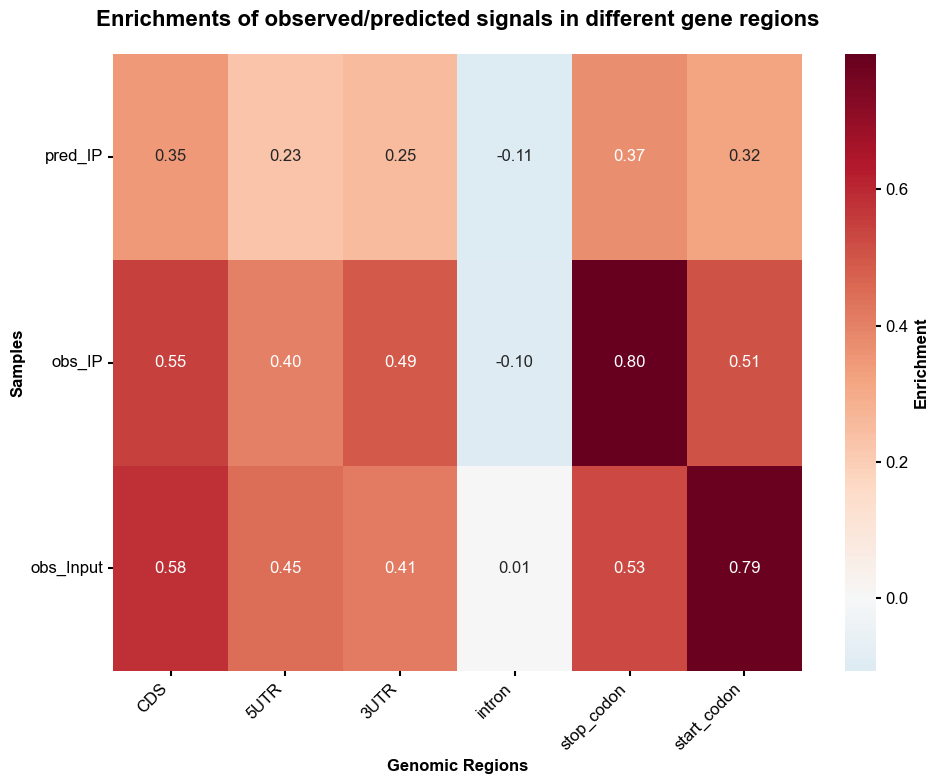

In [30]:
fig, ax = analyzer.create_enrichment_heatmap(
    enrichment_df, 
    title="Enrichments of observed/predicted signals in different gene regions"
)